# Notebook 02: Inverse design introduction

In this notebook we will inverse design a waveguide mode conversion device.

In [2]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

## Thick waveguides support more than one mode
`ceviche` has an in-built method `insert_mode` that looks for different modes that you can insert as sources!

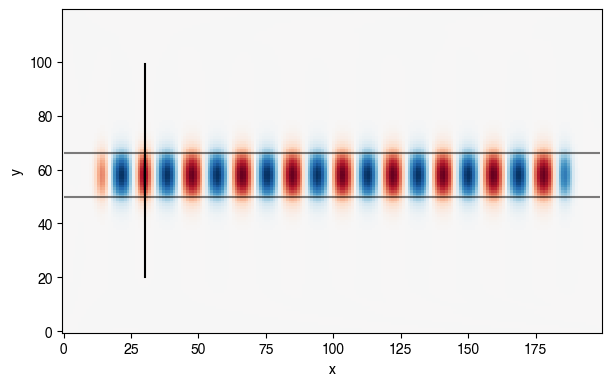

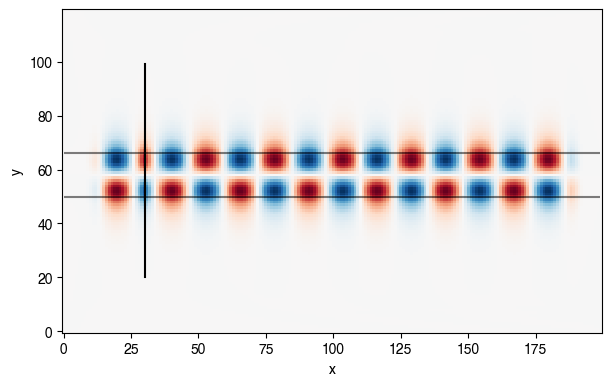

In [3]:
# Define simulation parameters (see above)
omega = 2*np.pi*200e12
dl = 25e-9

Nx = 200
Ny = 120
Npml = 20

# Define permittivity for a straight waveguide
epsr = np.ones((Nx, Ny))  
epsr[:,50:67] = 12

# Source position 
src_y = np.arange(20,100)
src_x = 30 * np.ones(src_y.shape, dtype=int)

# Source for mode 1
source1 = insert_mode(omega, dl, src_x, src_y, epsr, m=1)

# Source for mode 2
source2 = insert_mode(omega, dl, src_x, src_y, epsr, m=2)

# Run the simulation exciting mode 1
simulation = ceviche.fdfd_ez(omega, dl, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source1)

# Visualize the electric field
ax = ceviche.viz.real(Ez, outline=epsr, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

# Run the simulation exciting mode 2
simulation = ceviche.fdfd_ez(omega, dl, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source2)

# Visualize the electric field
ax = ceviche.viz.real(Ez, outline=epsr, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

plt.show()

## Optimize a device that converts mode 1 to mode 2
First, we define some helper functions for initialization and optimization

In [4]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    
    # Parametrization of the permittivity of the structure
    rho = np.zeros((Nx, Ny))  
    # Region within which the permittivity is allowed to change
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    
    # Output probe slice
    output_slice = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1.0
    
    epsr = epsr_min + (epsr_max-epsr_min)*rho
    bg_epsr = copy.deepcopy(epsr)
    return epsr, bg_epsr, design_region, input_slice, output_slice

def mask_combine_epsr(epsr, bg_epsr, design_region):
    """Utility function for combining the design region epsr and the background epsr
    """
    return epsr*design_region + bg_epsr*(design_region==0).astype(np.float)

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)

## Define all the parameters in the optimization 

- We will use an ADAM optimizer for the gradient descent.
- In the optimization, the structure is parametrized by a variable `rho` defined over the pixels that is bounded between 0 and 1. For the simulation, this is then converted to permittivity between `epsr_min` and `epsr_max`.

In [5]:
# Number of epochs in the optimization 
Nsteps=100
# Step size for the Adam optimizer
step_size=1e-1
# Angular frequency of the source in Hz
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=100
# Number of pixels in y-direction
Ny=100
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

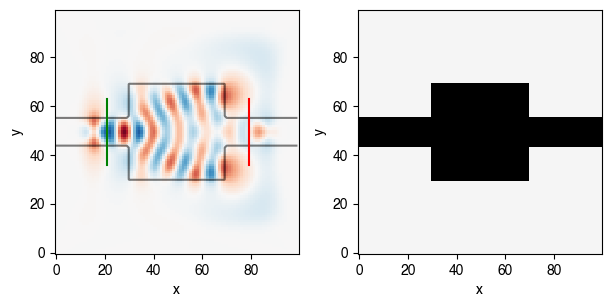

In [6]:
# Initialize the parametrization rho and the design region
epsr, bg_epsr, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr)

## Next, define the objective function for a mode converter

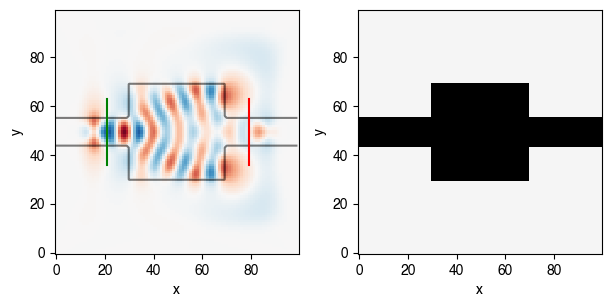

Epoch:   1/100 | Duration: 0.10 secs | Value: 1.544726e-13
Epoch:   2/100 | Duration: 0.10 secs | Value: 1.003286e-07
Epoch:   3/100 | Duration: 0.10 secs | Value: 2.018636e-07
Epoch:   4/100 | Duration: 0.10 secs | Value: 3.020135e-07
Epoch:   5/100 | Duration: 0.10 secs | Value: 3.993623e-07
Epoch:   6/100 | Duration: 0.10 secs | Value: 4.928770e-07
Epoch:   7/100 | Duration: 0.10 secs | Value: 5.818041e-07
Epoch:   8/100 | Duration: 0.10 secs | Value: 6.656485e-07
Epoch:   9/100 | Duration: 0.10 secs | Value: 7.441560e-07
Epoch:  10/100 | Duration: 0.10 secs | Value: 8.172875e-07
Epoch:  11/100 | Duration: 0.10 secs | Value: 8.851814e-07
Epoch:  12/100 | Duration: 0.10 secs | Value: 9.481121e-07
Epoch:  13/100 | Duration: 0.10 secs | Value: 1.006446e-06
Epoch:  14/100 | Duration: 0.10 secs | Value: 1.060603e-06
Epoch:  15/100 | Duration: 0.10 secs | Value: 1.111023e-06
Epoch:  16/100 | Duration: 0.10 secs | Value: 1.158140e-06
Epoch:  17/100 | Duration: 0.10 secs | Value: 1.202361e-

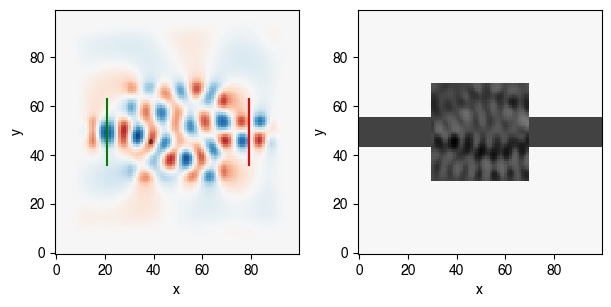

In [7]:
def measure_modes(Ez):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(Ez)*probe))

def objective(epsr):
    """Objective function called by optimizer
    
    1) Takes the epsr distribution as input
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    epsr = epsr.reshape((Nx, Ny))
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez)

# Simulate initial device
simulation, ax = viz_sim(epsr)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(epsr_optimum, loss) = adam_optimize(objective, epsr.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size)

# Simulate and show the optimal device
epsr_optimum = epsr_optimum.reshape((Nx, Ny))
simulation, ax = viz_sim(epsr_optimum)